# Land use and Land Cover Classification with Sentinel-2 Imagery

This notebook aims to map and quantify four broad land-cover classes—water bodies, vegetation, built-up/impervious surfaces, and bare soil/cropland—across a central Iowa agricultural AOI. Using high-resolution Sentinel-2 L2A surface-reflectance data, we compute three normalized‐difference indices (NDVI, NDWI, NDBI), and then compare two unsupervised approaches (rule-based thresholding vs. K-Means clustering) for each index. Finally, we evaluate their agreement via confusion matrices to identify the most robust method for each land-cover class.




In [2]:
! pip install rasterio

In [3]:
import os
import rasterio
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
#setting path
main_path = "/content/drive/MyDrive/project/S2A_MSIL2A_20250427T170711_N0511_R069_T15TVG_20250428T025712.SAFE/GRANULE/L2A_T15TVG_A051432_20250427T171119/IMG_DATA/"

## NDVI

### Creating a Benchmark: Normalized Difference Vegetation Index (NDVI)  
The NDVI is the most widely used indicator of live green vegetation, first introduced by Rouse et al. in 1973. It exploits the strong reflectance of healthy vegetation in the near-infrared and its absorption in the red portion of the spectrum:

NDVI = (NIR - RED) / (NIR + RED)

- **Sentinel-2 Bands:**  
  - **B04** → Red (665 nm, 10 m)  
  - **B08** → Near-Infrared (842 nm, 10 m)  
- **Typical Values:**  
  - **Dense vegetation:** NDVI > 0.5  
  - **Sparse vegetation or soil:** NDVI ≈ 0.2 – 0.5  
  - **Non-vegetated:** NDVI < 0.2  
- **Thresholding:**  
  In our Iowa AOI the NDVI histogram shows vegetation starting around **0.0210**, so we adopt **NDVI > 0.0210** to isolate green biomass.

---


### 1. Load & Stack Sentinel-2 Bands for NDVI

First we point to the 10 m Red (B04) and NIR (B08) bands, read them in with Rasterio, stack them into a 3D array, mask out any zero (no-data) pixels, and then compute the NDVI ratio.


In [5]:
import rasterio
import numpy as np

# Specify file paths to the bands being used
ndvi_bands_paths = {
    'B8': main_path + 'R10m/T15TVG_20250427T170711_B08_10m.jp2',   #NIR
    'B4': main_path + 'R10m/T15TVG_20250427T170711_B04_10m.jp2',   #RED
}

# Read and stack the band images
ndvi_band_data = []
for band in ['B4', 'B8']:
    with rasterio.open(ndvi_bands_paths[band]) as src:
        ndvi_band_data.append(src.read(1))

# Stack bands and create a mask for valid data (non-zero values in all bands)
ndvi_band_stack = np.dstack(ndvi_band_data)
ndvi_valid_data_mask = np.all(ndvi_band_stack > 0, axis=2)


# Calculating the NDVI
ndvi_red_band = ndvi_band_stack[:,:,0].astype(np.float16)
ndvi_nir_band = ndvi_band_stack[:,:,1].astype(np.float16)

ndvi = (ndvi_nir_band-ndvi_red_band)/(ndvi_nir_band+ndvi_red_band)

Getting threshold value

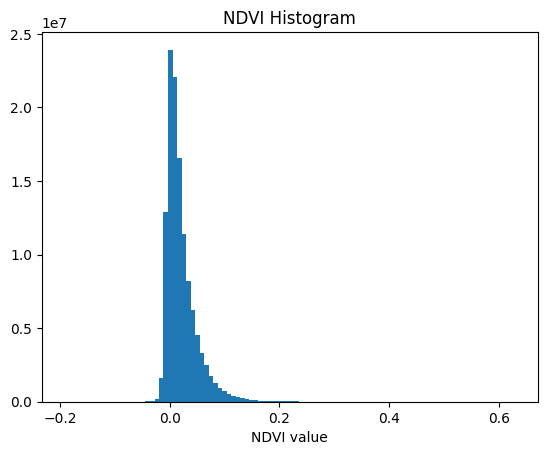

Mean NDWI (all valid pixels): 0.0210


In [6]:
# Getting our threshold value for NDVI in this region
plt.hist(ndvi[ndvi_valid_data_mask].flatten(), bins=100)
plt.title("NDVI Histogram")
plt.xlabel("NDVI value")
plt.show()
# assuming `ndwi` is your 2D NDWI array
# and `ndwi_valid_data_mask` is a boolean mask of valid pixels

mean_ndvi = ndvi[ndvi_valid_data_mask].mean()
print(f"Mean NDWI (all valid pixels): {mean_ndvi:.4f}")

In [7]:
# Thresholding the NDVI
threshold_ndvi = 0.0210 # Threshold value
mask_ndvi = np.where(ndvi > threshold_ndvi, 1, 0).astype(np.uint8)

Now, we can plot the rule-based mask

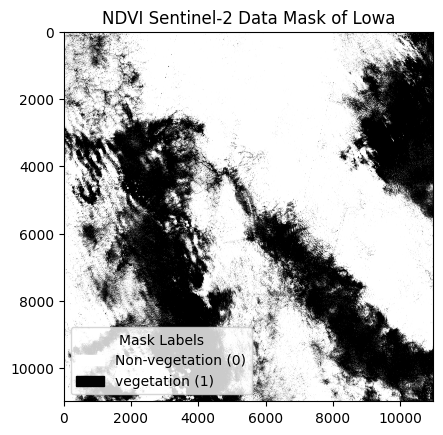

In [8]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Create legend
patches = [
    Rectangle((0, 0), 1, 1, color=plt.cm.binary(0)),  # Patch for color at vmin
    Rectangle((0, 0), 1, 1, color=plt.cm.binary(0.99)),  # Patch for color at vmax
]
labels = ['Non-vegetation (0)', 'vegetation (1)']
plt.legend(patches, labels, loc='lower left', title='Mask Labels')


# Plotting the result
plt.imshow(mask_ndvi, cmap='binary')
plt.title('NDVI Sentinel-2 Data Mask of Lowa')
plt.show()

Below we perform an unsupervised segmentation of our NDVI map using MiniBatch K-Means.

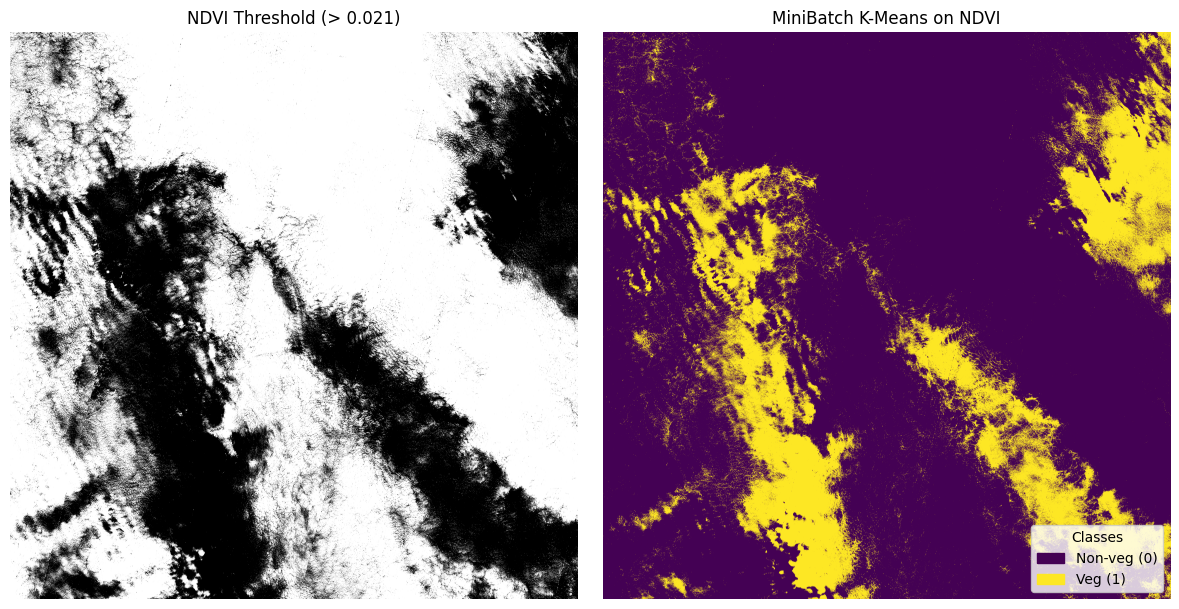

In [9]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle


# 1. Build feature vector from valid NDVI pixels
features_ndvi = ndvi[ndvi_valid_data_mask].reshape(-1, 1)

# 2. Fit MiniBatchKMeans (to avoid memory issues)
mbk_ndvi = MiniBatchKMeans(n_clusters=2, batch_size=10000, random_state=0)
mbk_ndvi.fit(features_ndvi)

# 3. Create a full‐res label grid
labels_ndvi = np.full(ndvi.shape, -1, dtype=int)
labels_ndvi[ndvi_valid_data_mask] = mbk_ndvi.predict(features_ndvi)

# 4. Identify which cluster is “vegetation” (higher mean NDVI)
cluster_means_ndvi = [
    ndvi[ndvi_valid_data_mask][labels_ndvi[ndvi_valid_data_mask] == i].mean()
    for i in (0, 1)
]
veg_cluster_ndvi = int(np.argmax(cluster_means_ndvi))

# 5. Make the binary K-Means mask (1=veg, 0=non-veg)
kmeans_mask_ndvi = (labels_ndvi == veg_cluster_ndvi).astype(np.uint8)
# 6. Plot Threshold vs K-Means (same shape & size)
fig, (ax_thr, ax_km) = plt.subplots(1, 2, figsize=(12, 6))

ax_thr.imshow(mask_ndvi, cmap='binary')
ax_thr.set_title(f'NDVI Threshold (> {threshold_ndvi})')
ax_thr.axis('off')

# K-Means NDVI with viridis
ax_km.imshow(kmeans_mask_ndvi, cmap='viridis')
ax_km.set_title('MiniBatch K-Means on NDVI')
ax_km.axis('off')

# 7. Legend for K-Means panel using Viridis endpoints
cmap = plt.cm.viridis
patches = [
    Rectangle((0, 0), 1, 1, color=cmap(0.0)),   # deep purple
    Rectangle((0, 0), 1, 1, color=cmap(1.0)),   # bright yellow
]
ax_km.legend(patches, ['Non-veg (0)', 'Veg (1)'],
             loc='lower right', title='Classes')

plt.tight_layout()
plt.show()

we compare the rule-based NDVI mask (mask_ndvi) against the K-Means NDVI mask (kmeans_mask_ndvi) over all valid pixels:

Overall accuracy: 82.72%


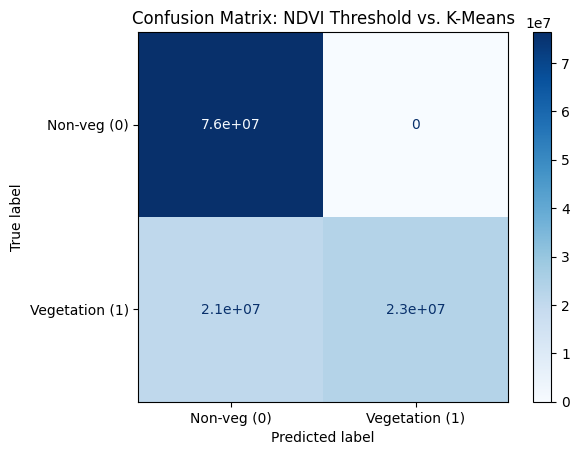

Confusion matrix:
 [[76377443        0]
 [20830918 23352039]]


In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score


# 1. Flatten only the valid pixels
thr_flat0 = mask_ndvi[ndvi_valid_data_mask].flatten()
km_flat0  = kmeans_mask_ndvi[ndvi_valid_data_mask].flatten()
accuracy = accuracy_score(thr_flat0, km_flat0)
print(f"Overall accuracy: {accuracy:.2%}")

# 2. Compute confusion matrix (rows=true classes, cols=predicted)
cm = confusion_matrix(thr_flat0, km_flat0, labels=[0, 1])

# 3. Plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['Non-veg (0)', 'Vegetation (1)'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix: NDVI Threshold vs. K-Means")
plt.show()

# 4. (Optional) Print raw numbers
print("Confusion matrix:\n", cm)

## NDWI

### Creating a Benchmark: Normalized Difference Water Index (NDWI)  
The NDWI was first introduced by Xu (2006) to map open-water bodies by comparing green and near-infrared reflectance:

NDWI= (Green – NIR)/(Green + NIR) → water bodies

- **Sentinel-2 Bands:**  
  - **B03** → Green (560 nm, 10 m)  
  - **B08** → Near-Infrared (842 nm, 10 m)  
- **Typical Values:**  
  - **Open water bodies:** NDWI > 0.5  
  - **Vegetation & moist soil:** NDWI ≈ 0.0 – 0.2  
  - **Built-up & dry soil:** NDWI ≈ –0.2 – 0.0  
- **Thresholding:**  
  In our Iowa AOI the NDWI histogram shows water features separating around **-0.0234**, so we adopt **NDWI > -0.0234** to reliably extract rivers, lakes, and ponds.

---


In [6]:
import rasterio
import numpy as np

# Specify file paths to the bands being used
ndwi_bands_paths = {
    'B8': main_path + 'R10m/T15TVG_20250427T170711_B08_10m.jp2',   #NIR
    'B3': main_path + 'R10m/T15TVG_20250427T170711_B03_10m.jp2',   #GREEN
}

# Read and stack the band images
ndwi_band_data = []
for band in ['B3', 'B8']:
    with rasterio.open(ndwi_bands_paths[band]) as src:
        ndwi_band_data.append(src.read(1))

# Stack bands and create a mask for valid data (non-zero values in all bands)
ndwi_band_stack = np.dstack(ndwi_band_data)
ndwi_valid_data_mask = np.all(ndwi_band_stack > 0, axis=2)


# Calculating the NDWI
ndwi_green_band = ndwi_band_stack[:,:,0].astype(np.float16)
ndwi_nir_band = ndwi_band_stack[:,:,1].astype(np.float16)

ndwi = (ndwi_green_band-ndwi_nir_band)/(ndwi_green_band+ndwi_nir_band)

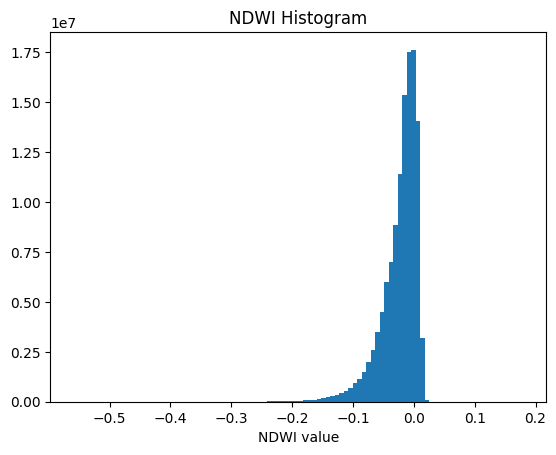

Mean NDWI (all valid pixels): -0.0234


In [7]:
plt.hist(ndwi[ndwi_valid_data_mask].flatten(), bins=100)
plt.title("NDWI Histogram")
plt.xlabel("NDWI value")
plt.show()
# assuming `ndwi` is your 2D NDWI array
# and `ndwi_valid_data_mask` is a boolean mask of valid pixels

mean_ndwi = ndwi[ndwi_valid_data_mask].mean()
print(f"Mean NDWI (all valid pixels): {mean_ndwi:.4f}")

In [8]:
# Thresholding the NDWI
threshold_ndwi = -0.0234 # Threshold value
mask_ndwi = np.where(ndwi > threshold_ndwi, 1, 0).astype(np.uint8)

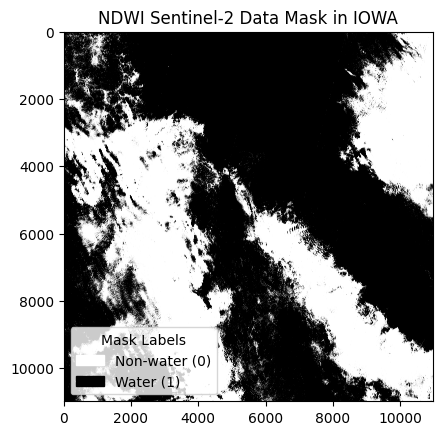

In [9]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Create legend
patches = [
    Rectangle((0, 0), 1, 1, color=plt.cm.binary(0)),  # Patch for color at vmin
    Rectangle((0, 0), 1, 1, color=plt.cm.binary(0.99)),  # Patch for color at vmax
]
labels = ['Non-water (0)', 'Water (1)']
plt.legend(patches, labels, loc='lower left', title='Mask Labels')


# Plotting the result
plt.imshow(mask_ndwi, cmap='binary')
plt.title('NDWI Sentinel-2 Data Mask in IOWA')
plt.show()

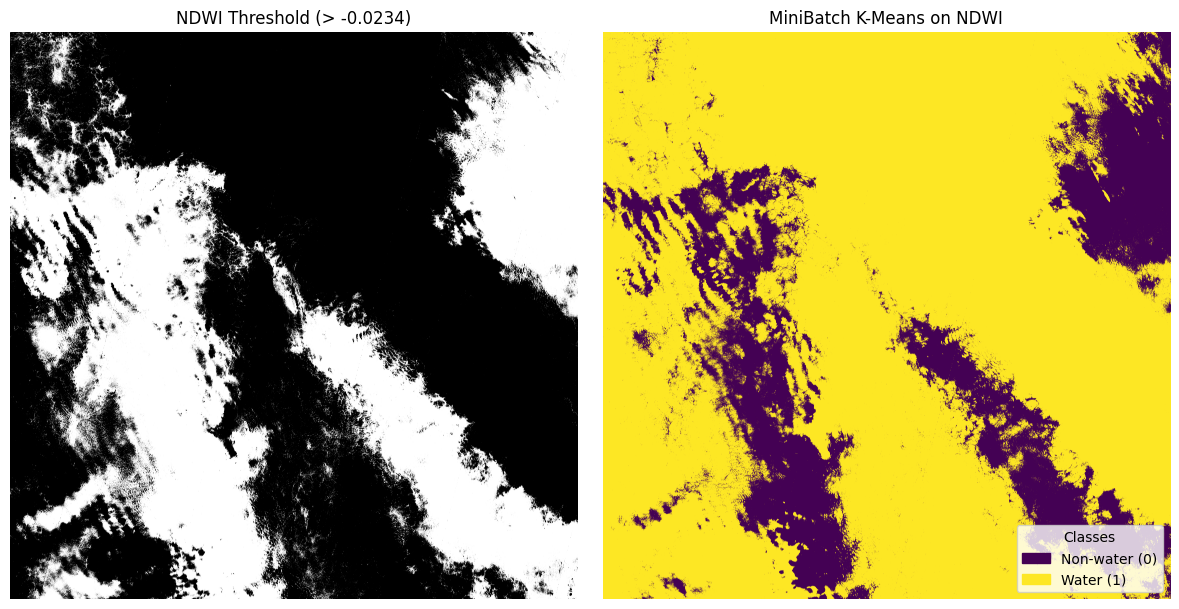

In [10]:
import numpy as np
from sklearn.cluster import MiniBatchKMeans
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# ——————————————————————————————————————————————
# Prerequisites (make sure you have these defined already):
#   ndwi                  = 2D array of NDWI values
#   ndwi_valid_data_mask  = boolean mask where NDWI is valid (e.g. not NaN)
#   mask_ndwi             = binary rule‐based mask: np.where(ndwi > threshold_ndwi, 1, 0)
#   threshold_ndwi        = your chosen NDWI cutoff (e.g. 0.0)
# ——————————————————————————————————————————————

# 1. Build feature vector from valid NDWI pixels
features_ndwi = ndwi[ndwi_valid_data_mask].reshape(-1, 1)

# 2. Fit MiniBatchKMeans (memory‐efficient)
mbk_ndwi = MiniBatchKMeans(n_clusters=2, batch_size=10000, random_state=0)
mbk_ndwi.fit(features_ndwi)

# 3. Create a full‐resolution label grid
labels_ndwi = np.full(ndwi.shape, -1, dtype=int)
labels_ndwi[ndwi_valid_data_mask] = mbk_ndwi.predict(features_ndwi)

# 4. Identify which cluster is “water” (higher mean NDWI)
cluster_means_ndwi = [
    ndwi[ndwi_valid_data_mask][labels_ndwi[ndwi_valid_data_mask] == i].mean()
    for i in (0, 1)
]
water_cluster_ndwi = int(np.argmax(cluster_means_ndwi))

# 5. Make the binary K-Means mask (1=water, 0=non-water)
kmeans_mask_ndwi = (labels_ndwi == water_cluster_ndwi).astype(np.uint8)

# 6. Plot Threshold vs K-Means (same shape & size)
fig, (ax_thr, ax_km) = plt.subplots(1, 2, figsize=(12, 6))

# Rule‐based NDWI threshold mask
ax_thr.imshow(mask_ndwi, cmap='binary')
ax_thr.set_title(f'NDWI Threshold (> {threshold_ndwi})')
ax_thr.axis('off')

# K‐Means NDWI mask (viridis)
ax_km.imshow(kmeans_mask_ndwi, cmap='viridis')
ax_km.set_title('MiniBatch K-Means on NDWI')
ax_km.axis('off')

# 7. Legend for K-Means panel using Viridis endpoints
cmap = plt.cm.viridis
patches = [
    Rectangle((0, 0), 1, 1, color=cmap(0.0)),  # deep purple = non-water
    Rectangle((0, 0), 1, 1, color=cmap(1.0)),  # bright yellow = water
]
ax_km.legend(patches, ['Non-water (0)', 'Water (1)'],
             loc='lower right', title='Classes')

plt.tight_layout()
plt.show()


Overall accuracy: 83.75%


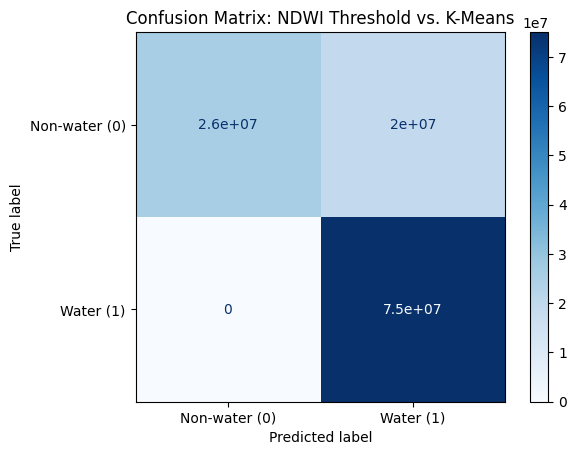

Confusion matrix:
 [[25953625 19588140]
 [       0 75018635]]


In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score


# 1. Flatten only the valid pixels
thr_flat1 = mask_ndwi[ndwi_valid_data_mask].flatten()
km_flat1  = kmeans_mask_ndwi[ndwi_valid_data_mask].flatten()
accuracy = accuracy_score(thr_flat1, km_flat1)
print(f"Overall accuracy: {accuracy:.2%}")

# 2. Compute confusion matrix (rows=true classes, cols=predicted)
cm = confusion_matrix(thr_flat1, km_flat1, labels=[0, 1])

# 3. Plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['Non-water (0)', 'Water (1)'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix: NDWI Threshold vs. K-Means")
plt.show()

# 4. (Optional) Print raw numbers
print("Confusion matrix:\n", cm)

## NDBI
### Creating a Benchmark: Normalized Difference Built-Up Index (NDBI)  
The NDBI was proposed by Zha, Gao & Ni in 2003 to highlight urban and impervious surfaces, by contrasting SWIR reflectance (higher over concrete/asphalt) with NIR:

$$
\mathrm{NDBI} = \frac{\text{SWIR} - \text{NIR}}{\text{SWIR} + \text{NIR}}
$$

- **Sentinel-2 Bands:**  
  - **B08** → Near-Infrared (842 nm, 10 m)  
  - **B11** → Short-Wave Infrared (1610 nm, 20 m)  
- **Typical Values:**  
  - **Built-up areas:** NDBI > 0  
  - **Non-urban:** NDBI ≈ –0.2 – 0  
- **Thresholding:**  
  After up-sampling B11 to 10 m, the NDBI values in our scene cluster around zero, so we use **NDBI > -0.0975** to detect built-up pixels.



In [12]:
import rasterio
import numpy as np

# Specify file paths to the bands being used
NDBI_bands_paths = {
    'B8A': main_path + 'R20m/T15TVG_20250427T170711_B8A_20m.jp2',
    'B11': main_path + 'R20m/T15TVG_20250427T170711_B11_20m.jp2'
}
# Read and stack the band images
NDBI_band_data = []
for band in ['B8A', 'B11']:
    with rasterio.open(NDBI_bands_paths[band]) as src:
        NDBI_band_data.append(src.read(1))

# Stack bands and create a mask for valid data (non-zero values in all bands)
NDBI_band_stack = np.dstack(NDBI_band_data)
NDBI_valid_data_mask = np.all(NDBI_band_stack > 0, axis=2)

# Calculating the NDBI
NDBI_nir_band = NDBI_band_stack[:,:,0].astype(np.float16)
NDBI_swir_band = NDBI_band_stack[:,:,1].astype(np.float16)


NDBI = (NDBI_swir_band-NDBI_nir_band)/(NDBI_nir_band+NDBI_swir_band)

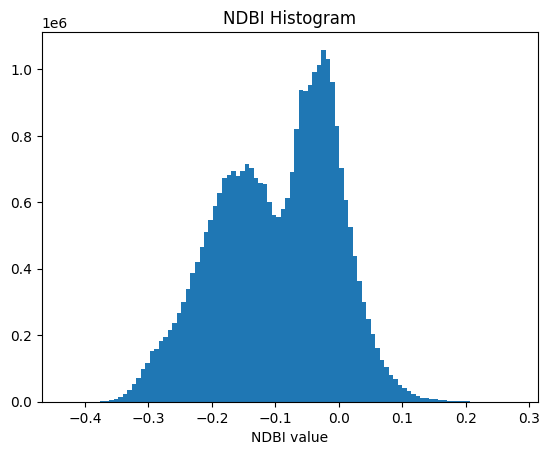

Mean NDBI (all valid pixels): -0.0975


In [13]:
plt.hist(NDBI[NDBI_valid_data_mask].flatten(), bins=100)
plt.title("NDBI Histogram")
plt.xlabel("NDBI value")
plt.show()


mean_ndbi = NDBI[NDBI_valid_data_mask].mean()
print(f"Mean NDBI (all valid pixels): {mean_ndbi:.4f}")

In [14]:
# Thresholding the NDBI
threshold_ndbi = -0.0975 # Threshold value
mask_ndbi = np.where(NDBI> threshold_ndbi, 1, 0).astype(np.uint8)

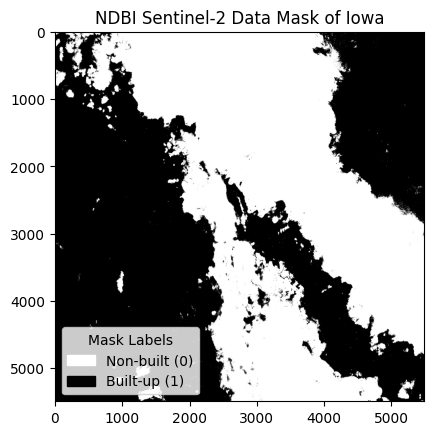

In [15]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Create legend
patches = [
    Rectangle((0, 0), 1, 1, color=plt.cm.binary(0)),  # Patch for color at vmin
    Rectangle((0, 0), 1, 1, color=plt.cm.binary(0.99)),  # Patch for color at vmax
]
labels = ['Non-built (0)', 'Built-up (1)']
plt.legend(patches, labels, loc='lower left', title='Mask Labels')


# Plotting the result
plt.imshow(mask_ndbi, cmap='binary')
plt.title('NDBI Sentinel-2 Data Mask of Iowa')
plt.show()

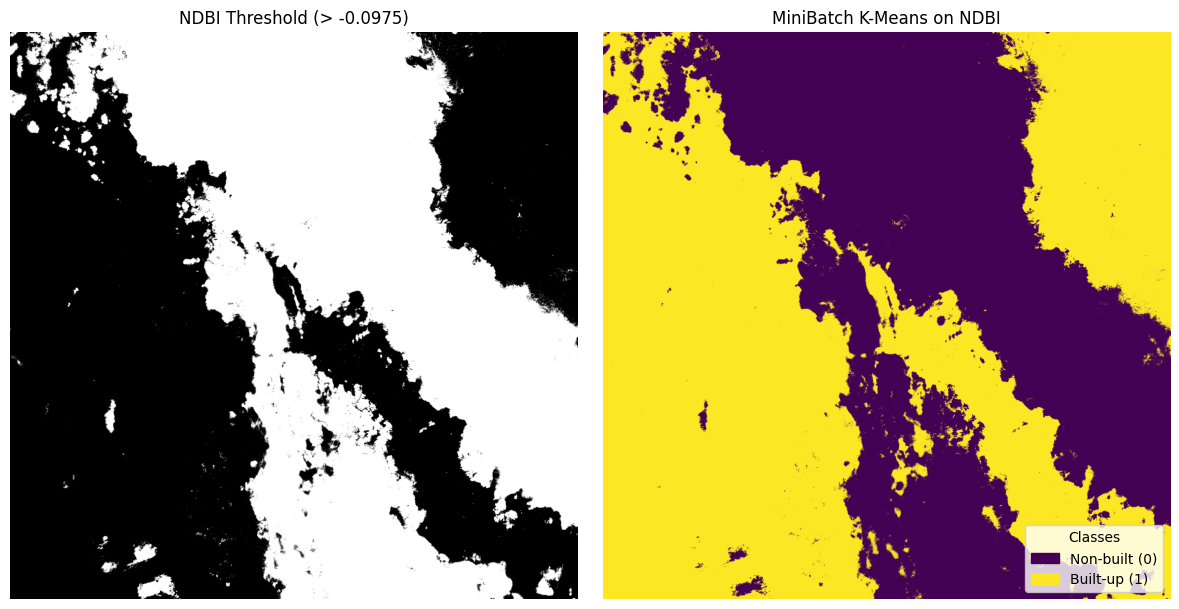

In [16]:
import numpy as np
from sklearn.cluster import MiniBatchKMeans
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# ——————————————————————————————————————————————
# Prerequisites (make sure you have these defined already):
#   ndbi                  = 2D array of NDBI values
#   ndbi_valid_data_mask  = boolean mask where NDBI is valid (e.g. not NaN)
#   mask_ndbi             = binary rule‐based mask: np.where(ndbi > threshold_ndbi, 1, 0)
#   threshold_ndbi        = your chosen NDBI cutoff (e.g. 0.0)
# ——————————————————————————————————————————————

# 1. Build feature vector from valid NDBI pixels
features_ndbi = NDBI[NDBI_valid_data_mask].reshape(-1, 1)

# 2. Fit MiniBatchKMeans (memory‐efficient)
mbk_ndbi = MiniBatchKMeans(n_clusters=2, batch_size=10000, random_state=0)
mbk_ndbi.fit(features_ndbi)

# 3. Create a full‐resolution label grid
labels_ndbi = np.full(NDBI.shape, -1, dtype=int)
labels_ndbi[NDBI_valid_data_mask] = mbk_ndbi.predict(features_ndbi)

# 4. Identify which cluster is “built-up” (higher mean NDBI)
cluster_means_ndbi = [
    NDBI[NDBI_valid_data_mask][labels_ndbi[NDBI_valid_data_mask] == i].mean()
    for i in (0, 1)
]
built_cluster_ndbi = int(np.argmax(cluster_means_ndbi))

# 5. Make the binary K-Means mask (1=built-up, 0=non-built)
kmeans_mask_ndbi = (labels_ndbi == built_cluster_ndbi).astype(np.uint8)

# 6. Plot Threshold vs K-Means (same shape & size)
fig, (ax_thr, ax_km) = plt.subplots(1, 2, figsize=(12, 6))

# Rule‐based NDBI threshold mask
ax_thr.imshow(mask_ndbi, cmap='binary')
ax_thr.set_title(f'NDBI Threshold (> {threshold_ndbi})')
ax_thr.axis('off')

# K‐Means NDBI mask (viridis)
ax_km.imshow(kmeans_mask_ndbi, cmap='viridis')
ax_km.set_title('MiniBatch K-Means on NDBI')
ax_km.axis('off')

# 7. Legend for K-Means panel using Viridis endpoints
cmap = plt.cm.viridis
patches = [
    Rectangle((0, 0), 1, 1, color=cmap(0.0)),  # deep purple = non-built
    Rectangle((0, 0), 1, 1, color=cmap(1.0)),  # bright yellow = built-up
]
ax_km.legend(patches, ['Non-built (0)', 'Built-up (1)'],
             loc='lower right', title='Classes')

plt.tight_layout()
plt.show()


Calculating the confusion matrix

Overall accuracy: 97.83%


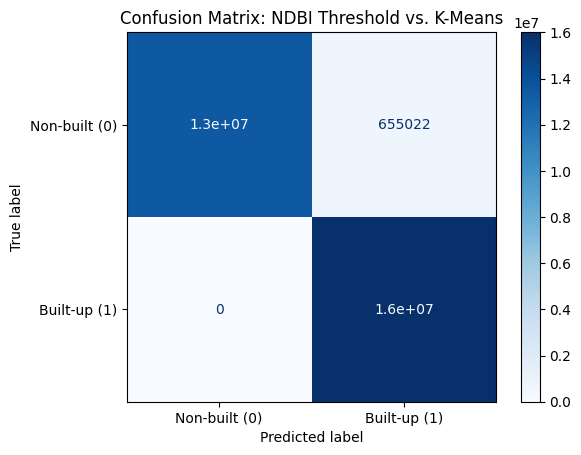

Confusion matrix:
 [[13470742   655022]
 [       0 16014336]]
CPU times: user 3.72 s, sys: 356 ms, total: 4.08 s
Wall time: 4.4 s


In [19]:
# check run time
%%time
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score



# 1. Flatten only the valid pixels
thr_flat2 = mask_ndbi[NDBI_valid_data_mask].flatten()
km_flat2  = kmeans_mask_ndbi[NDBI_valid_data_mask].flatten()
# thr_flat and km_flat from before
accuracy = accuracy_score(thr_flat2, km_flat2)
print(f"Overall accuracy: {accuracy:.2%}")
# 2. Compute confusion matrix (rows=true classes, cols=predicted)
cm = confusion_matrix(thr_flat2, km_flat2, labels=[0, 1])

# 3. Plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['Non-built (0)', 'Built-up (1)'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix: NDBI Threshold vs. K-Means")
plt.show()

# 4. (Optional) Print raw numbers
print("Confusion matrix:\n", cm)

## Conclusion

Across our three unsupervised workflows, the built-up index (NDBI) showed the strongest agreement—∼97%—between simple thresholding and K-Means clustering, reflecting the clear spectral separation of impervious surfaces in SWIR vs. NIR bands. In contrast, vegetation (NDVI) and water (NDWI) both achieved below 90% agreement.
These results suggest that:

**1.** Built-up detection can rely on either rule-based or clustering methods with confidence.  

**2.** Vegetation and water mapping benefit from more flexible approaches: dynamic (histogram‐driven) thresholds, pre-masking of clouds/shadows, or simple supervised models that combine multiple indices.

## Resource & Energy Use

Each index (NDVI, NDWI, NDBI) was run in its own cell to prevent crashes, and total runtime after execution (the wall-time) was recorded

| Index |   Time   | Peak RAM |
| :---: | :------: | :------: |
|  NDVI | 2.42 min |  5.0 GB  |
|  NDWI | 2.30 min |  5.3 GB  |
|  NDBI | 2.20 min |  5.8 GB  |


### Energy & Carbon Estimate:
  
Assuming a 50 W average draw, total compute energy was ~0.0058 kWh.  
At 0.4 kg CO₂e/kWh, that corresponds to ~0.0023 kg CO₂e (kilograms of greenhouse-gas emissions) for the full analysis(CO₂e = carbon-dioxide equivalent).


| Index | Time (h)            | Energy (kWh) = 50 W × Time        |
| ----- | ------------------- | --------------------------------- |
| NDVI  | 2.42 min ≈ 0.0403 h | 0.050 kW × 0.0403 h ≈ 0.00202 kWh |
| NDWI  | 2.30 min ≈ 0.0383 h | 0.050 kW × 0.0383 h ≈ 0.00192 kWh |
| NDBI  | 2.20 min ≈ 0.0367 h | 0.050 kW × 0.0367 h ≈ 0.00184 kWh |


### However, other sources may also add to the carbon footprint:

**Data acquisition**: downloading and ingesting large satellite files requires energy in network hardware and remote servers.

**Pre-processing & storage**: decompressing, converting formats, and keeping the data on disk all draw extra power.

**Cloud infrastructure overhead**: running code in a managed environment incurs additional energy for virtualization, storage systems, and cooling, beyond the CPU’s own consumption.